In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.datasets import reuters

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=100000)

2110848/2110848 [==============================] - 0s 0us/step


In [4]:
glove_path = '/content/drive/MyDrive/'                                            
glove_file = '/content/drive/MyDrive/glove.6B.100d.txt'
 
embedding_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_index[word] = coefs

print("Number of word vectors:", len(embedding_index))

Number of word vectors: 400000


In [5]:
word_index = reuters.get_word_index()
embedding_dim = 100
match = 0
misses = 0

embedding_matrix = np.zeros((100000, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        match += 1
    else:
        misses += 1
        
print(embedding_matrix.shape)
print("Number of matches:", match)
print("Number of misses:", misses)

550378/550378 [==============================] - 0s 0us/step
(100000, 100)
Number of matches: 24975
Number of misses: 6004


In [6]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen=128)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,maxlen=128)
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [7]:
inputShape = tf.keras.layers.Input(shape=(128))

embedding_layer = tf.keras.layers.Embedding(
    100000,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

embeddings = embedding_layer(inputShape)
x = tf.keras.layers.Flatten()(embeddings)
x = tf.keras.layers.Dense(128,activation='sigmoid')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(46,activation='softmax')(x)

model1 = tf.keras.Model(inputs = inputShape, outputs = x)

model1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 100)          10000000  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 128)               1638528   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 46)                5934      
                                                                 
Total params: 11,644,462
Trainable params: 1,644,462
Non-trai

In [8]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/reuters-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-3)


model1.compile(
    loss = 'categorical_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history1 = model1.fit(
    x_train,y_train,
    epochs = 10,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=my_callbacks)

Epoch 1/10
71/71 [==============================] - 8s 75ms/step - loss: 2.2686 - accuracy: 0.4132 - val_loss: 2.0366 - val_accuracy: 0.4657 - lr: 0.0010
Epoch 2/10
71/71 [==============================] - 4s 58ms/step - loss: 1.9023 - accuracy: 0.5039 - val_loss: 1.9450 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 3/10
71/71 [==============================] - 4s 62ms/step - loss: 1.6154 - accuracy: 0.5868 - val_loss: 1.8983 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 4/10
71/71 [==============================] - 5s 75ms/step - loss: 1.3221 - accuracy: 0.6690 - val_loss: 1.8846 - val_accuracy: 0.5151 - lr: 0.0010
Epoch 5/10
71/71 [==============================] - 4s 59ms/step - loss: 1.0532 - accuracy: 0.7484 - val_loss: 1.8827 - val_accuracy: 0.5169 - lr: 0.0010
Epoch 6/10
71/71 [==============================] - 0s 4ms/step - loss: 0.8155 - accuracy: 0.8152 - val_loss: 1.9126 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 7/10
71/71 [==============================] - 4s 59ms/step - loss: 0.61

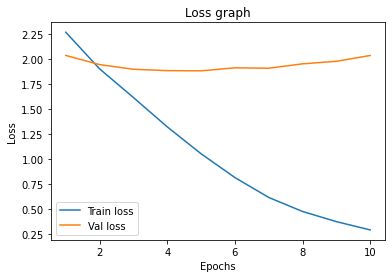

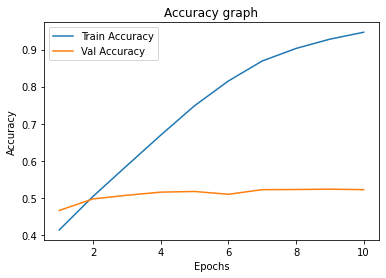

In [9]:
# Plot training process
dict1 = history1.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()

#print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [30]:
inputShape = tf.keras.layers.Input(shape=(128))

embedding_layer = tf.keras.layers.Embedding(
    100000,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

embeddings = embedding_layer(inputShape)
x = tf.keras.layers.LSTM(64,dropout=0.1)(embeddings)

x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(46,activation='softmax')(x)

model2 = tf.keras.Model(inputs = inputShape, outputs = x)

model2.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 128, 100)          10000000  
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 46)                2990      
                                                                 
Total params: 10,049,390
Trainable params: 49,390
Non-train

In [33]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/reuters-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-3)


model2.compile(
    loss = 'categorical_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history2 = model2.fit(
    x_train,y_train,
    epochs = 40,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=my_callbacks)

Epoch 1/40
71/71 [==============================] - 7s 80ms/step - loss: 1.7446 - accuracy: 0.5450 - val_loss: 1.7293 - val_accuracy: 0.5539 - lr: 0.0010
Epoch 2/40
71/71 [==============================] - 1s 13ms/step - loss: 1.7165 - accuracy: 0.5485 - val_loss: 1.7187 - val_accuracy: 0.5516 - lr: 0.0010
Epoch 3/40
71/71 [==============================] - 4s 63ms/step - loss: 1.6797 - accuracy: 0.5589 - val_loss: 1.6860 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 4/40
71/71 [==============================] - 5s 69ms/step - loss: 1.6466 - accuracy: 0.5681 - val_loss: 1.6832 - val_accuracy: 0.5717 - lr: 0.0010
Epoch 5/40
71/71 [==============================] - 1s 13ms/step - loss: 1.6204 - accuracy: 0.5773 - val_loss: 1.6686 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 6/40
71/71 [==============================] - 5s 65ms/step - loss: 1.5923 - accuracy: 0.5832 - val_loss: 1.6935 - val_accuracy: 0.5744 - lr: 0.0010
Epoch 7/40
71/71 [==============================] - 5s 69ms/step - loss: 1.5

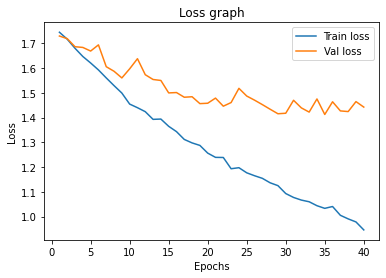

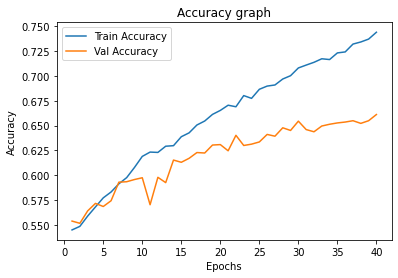

In [34]:
# Plot training process
dict1 = history2.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()

#print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [14]:
inputShape = tf.keras.layers.Input(shape=(128))

embedding_layer = tf.keras.layers.Embedding(
    100000,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

embeddings = embedding_layer(inputShape)
x = tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.1)(embeddings)
x = tf.keras.layers.LSTM(128,dropout=0.1)(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(46,activation='softmax')(x)

model2 = tf.keras.Model(inputs = inputShape, outputs = x)

model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 128, 100)          10000000  
                                                                 
 lstm_3 (LSTM)               (None, 128, 128)          117248    
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 46)                2990

In [27]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/reuters2-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-3)


model2.compile(
    loss = 'categorical_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history2 = model2.fit(
    x_train,y_train,
    epochs = 30,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=my_callbacks)

Epoch 1/30
71/71 [==============================] - 11s 122ms/step - loss: 1.0910 - accuracy: 0.7150 - val_loss: 1.4525 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 2/30
71/71 [==============================] - 5s 78ms/step - loss: 1.0473 - accuracy: 0.7266 - val_loss: 1.4806 - val_accuracy: 0.6567 - lr: 0.0010
Epoch 3/30
71/71 [==============================] - 2s 24ms/step - loss: 1.0054 - accuracy: 0.7337 - val_loss: 1.4617 - val_accuracy: 0.6514 - lr: 0.0010
Epoch 4/30
71/71 [==============================] - 2s 23ms/step - loss: 0.9904 - accuracy: 0.7394 - val_loss: 1.5528 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/30
71/71 [==============================] - 2s 23ms/step - loss: 1.0009 - accuracy: 0.7338 - val_loss: 1.4944 - val_accuracy: 0.6527 - lr: 0.0010
Epoch 6/30
71/71 [==============================] - 2s 23ms/step - loss: 0.9454 - accuracy: 0.7460 - val_loss: 1.4519 - val_accuracy: 0.6483 - lr: 0.0010
Epoch 7/30
71/71 [==============================] - 6s 81ms/step - loss: 0

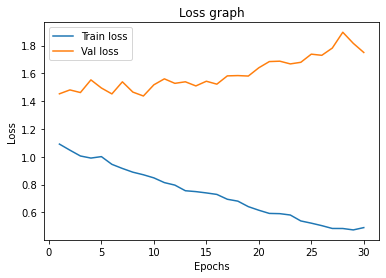

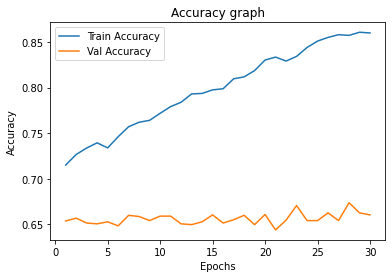

In [28]:
# Plot training process
dict1 = history2.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()

#print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [29]:
predict = model2.evaluate(x_test,y_test)
print(predict)

71/71 [==============================] - 1s 9ms/step - loss: 1.7499 - accuracy: 0.6603
[1.7499217987060547, 0.6602849364280701]
